In [2]:
import os
import json
from recordtype import recordtype
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters

import dadrah.util.data_processing as dapr
import dadrah.selection.qr_workflow as qrwf

## params

In [3]:
params_t = recordtype('Parameters','qr_run_n, sig_sample_id, sig_xsec, poly_order, kfold_n')
params = params_t(qr_run_n = 31, sig_sample_id='GtoWW35naReco', sig_xsec=0, poly_order=5, kfold_n=5) 
quantiles = [0.3, 0.5, 0.7, 0.9]

## paths

In [4]:
envelope_dir = '/eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_'+str(params.qr_run_n)+'/sig_GtoWW35naReco/xsec_'+str(params.sig_xsec)+'/loss_rk5_05/envelope'
polys_json_path = os.path.join(envelope_dir, 'polynomials_allQ_allFolds_'+ params.sig_sample_id + '_xsec_' + str(params.sig_xsec) + '.json')
fig_dir = '../fig/poly_analysis/'

## read envelope

In [5]:
bin_idx, mu_idx, rmse_idx, min_idx, max_idx = range(5)

envelope_per_fold = {}
for k in range(params.kfold_n+1):
    envelope_json_path = os.path.join(envelope_dir, 'cut_stats_allQ_fold'+str(k+1)+'_'+ params.sig_sample_id + '_xsec_' + str(params.sig_xsec) + '.json')
    ff = open(envelope_json_path)
    envelope_per_fold['fold_{}'.format(k+1)] = json.load(ff)

# fitting functions

## generic fitting

In [6]:
def fit_poly_from_envelope(fit_fun, uncert_fun, degree, envelope, quantiles):
    
    bin_idx, mu_idx, rmse_idx, min_idx, max_idx = range(5)

    fits = {}

    for qq in quantiles:

        qq_key = str(qq)
        env_qq = np.asarray(envelope[qq_key])

        x      = env_qq[:,bin_idx]
        y      = env_qq[:,mu_idx]
        uncert = uncert_fun(env_qq)        
        cc = fit_fun(degree, x, y, uncert)
        
        fits[qq] = np.poly1d(cc)

    return fits

In [7]:
def fit_poly_from_envelope_forall_folds(fit_fun, uncert_fun, degree, envelope_per_fold, quantiles, params):
    
    poly_fits_per_fold = {}
    
    for k in range(params.kfold_n+1):
        poly_fits = fit_poly_from_envelope(fit_fun, uncert_fun, degree, envelope_per_fold['fold_{}'.format(k+1)], quantiles)
        poly_fits_per_fold['fold_{}'.format(k+1)] = poly_fits
    
    return poly_fits_per_fold

## poly1d weighted fit

In [8]:
def fit_poly1d_coeff(degree, x, y, uncert):
    return np.polyfit(x, y, degree, w=uncert)

## curve fit

In [9]:
def poly_wrap(x, *p):
    return np.poly1d(p)(x)

In [10]:
def fit_curve_coeff(degree, x, y, uncert):
    cc, _ = sp.optimize.curve_fit(poly_wrap, x, y, np.ones(degree), sigma=uncert)
    return cc

## lm fit

In [11]:
def residual(params, x, y, uncert):
    y_hat = np.poly1d(params)(x)
    return (y - y_hat)/uncert

In [12]:
def fit_lm_coeff(degree, x, y, uncert):
    
    params_lmfit = Parameters()
    for d in range(degree):
        params_lmfit.add('c'+str(d), value=1)
    
    out = minimize(residual, params_lmfit, args=(x, y, uncert))

    return [out.params[n].value for n in out.var_names]

## uncertainty functions

In [13]:
def uncertainty_rmse(envelope):
    return envelope_q[:,rmse_idx]

In [14]:
def uncertainty_yerr(envelope):
    y = envelope[:,mu_idx]
    return [y-envelope[:,min_idx], envelope[:,max_idx]-y]

In [15]:
def uncertainty_stddev(envelope):
    return (envelope[:,max_idx]-envelope[:,min_idx])/4

In [16]:
def uncertainty_stddev_fixp(envelope, fix_point_n=3):
    sigma = (envelope[:,max_idx]-envelope[:,min_idx])/4
    sigma[:fix_point_n] = 1e-5
    return sigma

In [17]:
def uncertainty_updown(envelope):
    y      = envelope[:,mu_idx]
    y_down = np.fabs(y-envelope[:,min_idx])
    y_up   = np.fabs(y-envelope[:,max_idx])
    return 1./(y_down+y_up)

## plotting functions

In [18]:
def plot_poly_fits(envelope_per_fold, poly_fits_per_fold, quantiles, params, plot_name_suffix):
    
    bin_idx, mu_idx, rmse_idx, min_idx, max_idx = range(5)
    
    for q in quantiles:
        
        fig, axs = plt.subplots(2, params.kfold_n+1, figsize=(30,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
        
        for k, ax, ax_ratio in zip(range(params.kfold_n+1), axs.flat, axs.flat[int(len(axs.flat)/2):]):
            
            envelope_q = np.asarray(envelope_per_fold['fold_{}'.format(k+1)][str(q)])
            poly_fit_q = poly_fits_per_fold['fold_{}'.format(k+1)][q]
            
            x = envelope_q[:,bin_idx]
            y = envelope_q[:,mu_idx]
            y_hat = poly_fit_q(x)
            yerr = [y-envelope_q[:,min_idx], envelope_q[:,max_idx]-y]
            
            ax.errorbar(x, y, yerr=yerr, fmt='o', ms=1.5, zorder=1)
            ax.plot(x, y_hat, c='r',lw=1, zorder=2)
            ax.set_title('fold {}'.format(k+1))
            
            ax_ratio.plot(x, y/y_hat, 'o', ms=1.7)
            ax_ratio.grid(True, which='major', axis='y')
            ax_ratio.set_ylim([0.995,1.005])
        
        for ax in axs.flat:
            ax.label_outer()
        
        plt.suptitle('quantile {}'.format(q))
        plt.savefig(fig_dir+'poly_fit_q{}_{}.pdf'.format(int(q*100), plot_name_suffix))
        plt.show()

In [19]:
np.set_printoptions(precision=5, suppress=True)

# poly1d fits

In [20]:
def compute_poly1d_fits(degree, envelope_per_fold, quantiles, params):
    fit_fun = fit_poly1d_coeff
    uncert_fun = uncertainty_updown
    return fit_poly_from_envelope_forall_folds(fit_fun, uncert_fun, degree, envelope_per_fold, quantiles, params)

### degree = 3

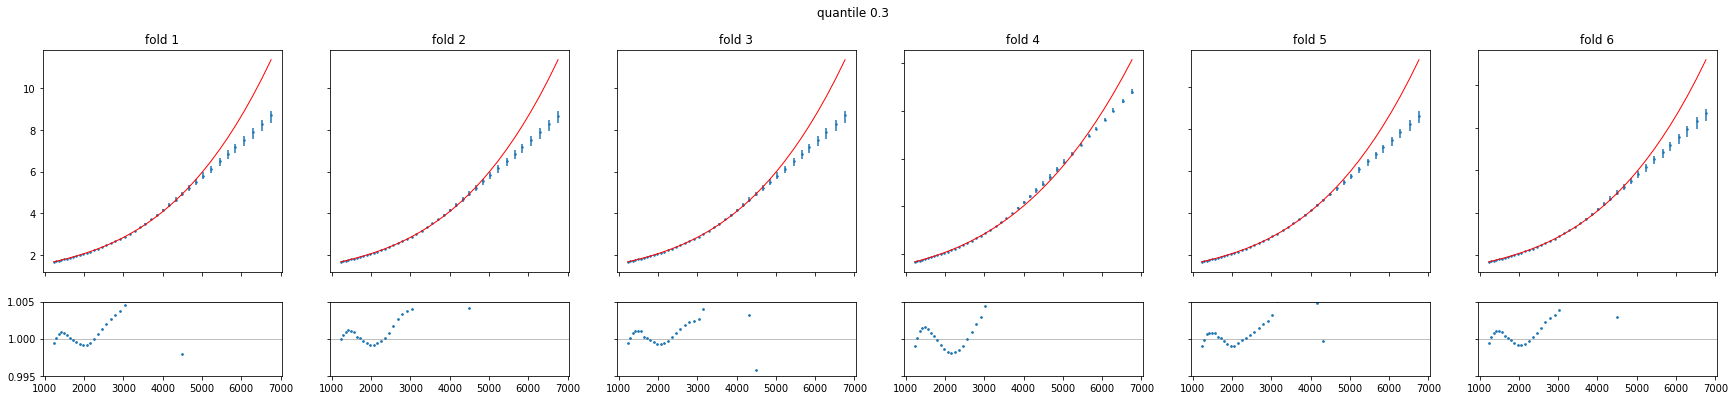

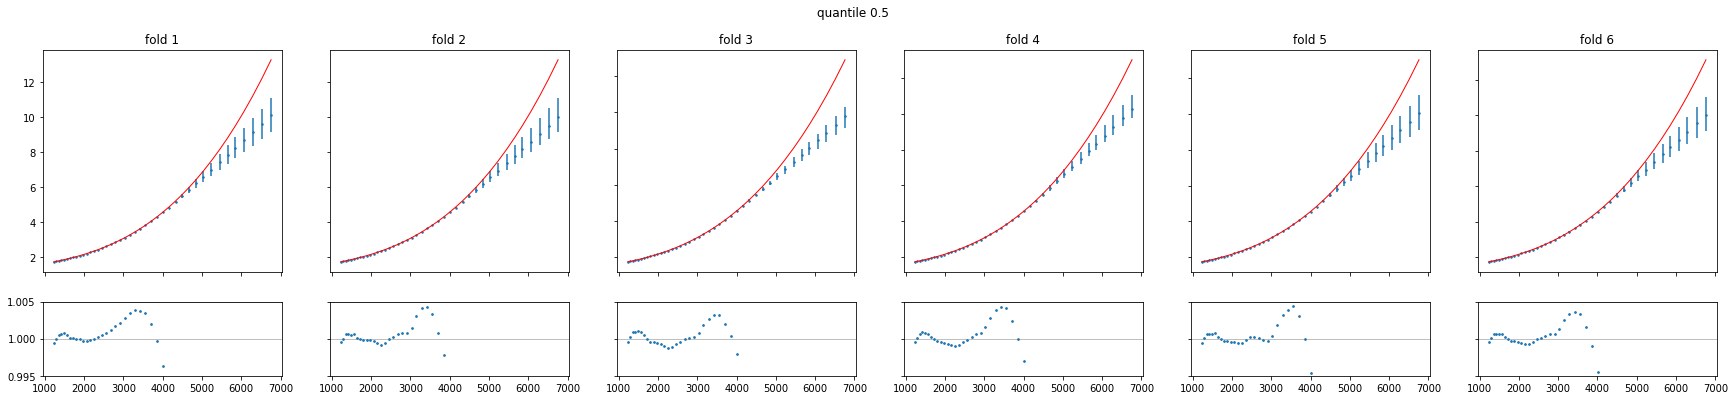

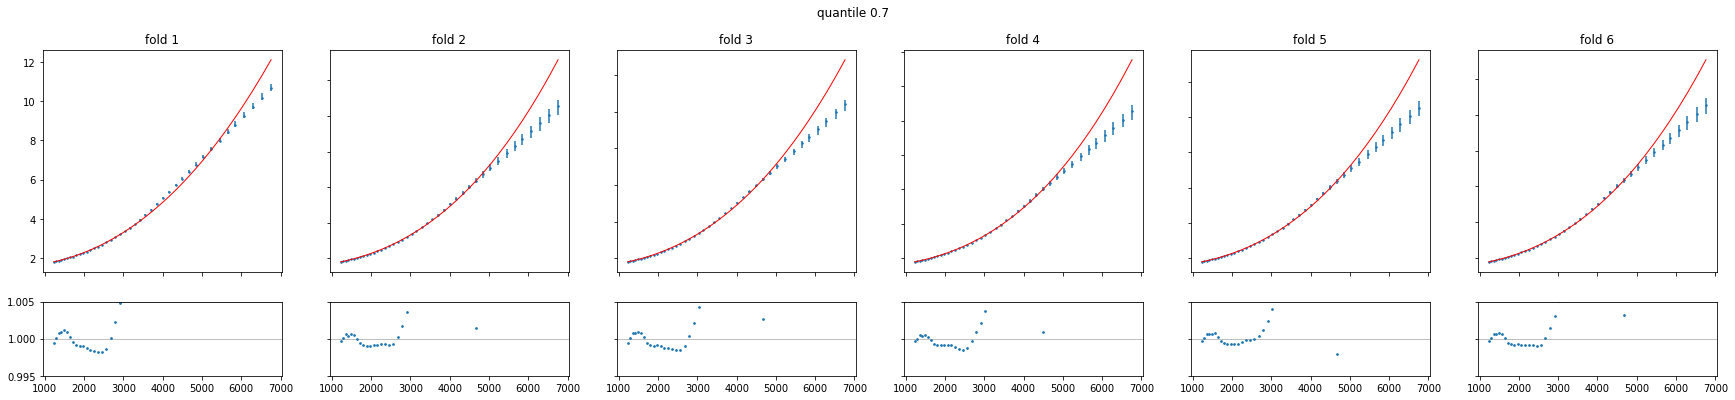

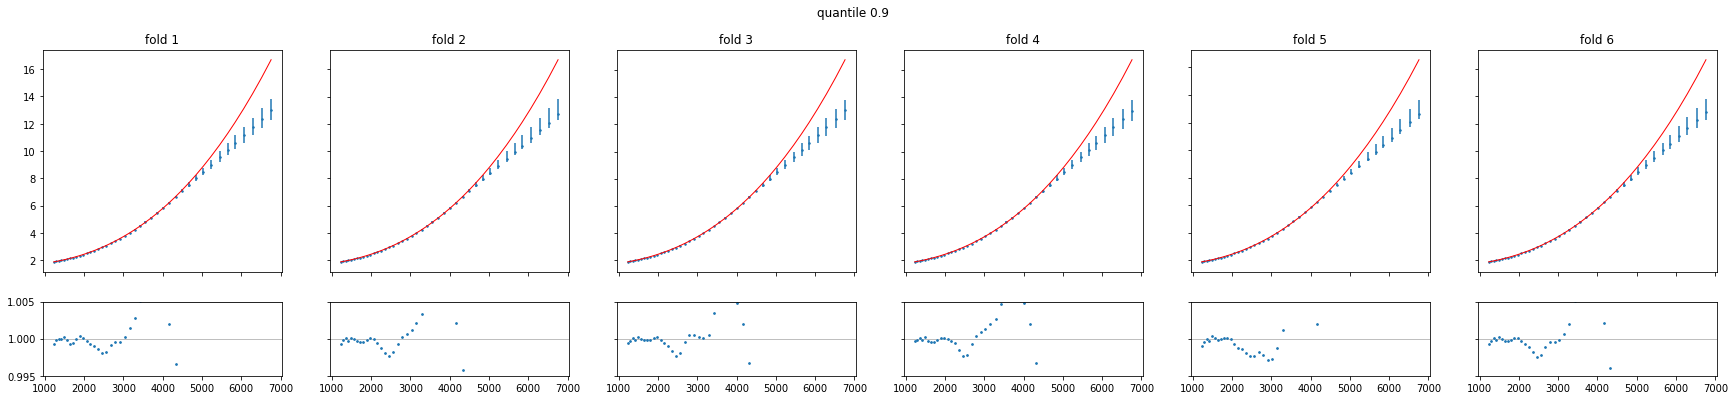

In [21]:
deg = 3
polynomials_per_fold_ord3 = compute_poly1d_fits(deg, envelope_per_fold, quantiles, params) # per kfold -> per quantile
plot_poly_fits(envelope_per_fold, polynomials_per_fold_ord3, quantiles, params, 'np_polyfit_ord'+str(deg))

### degree = 4 

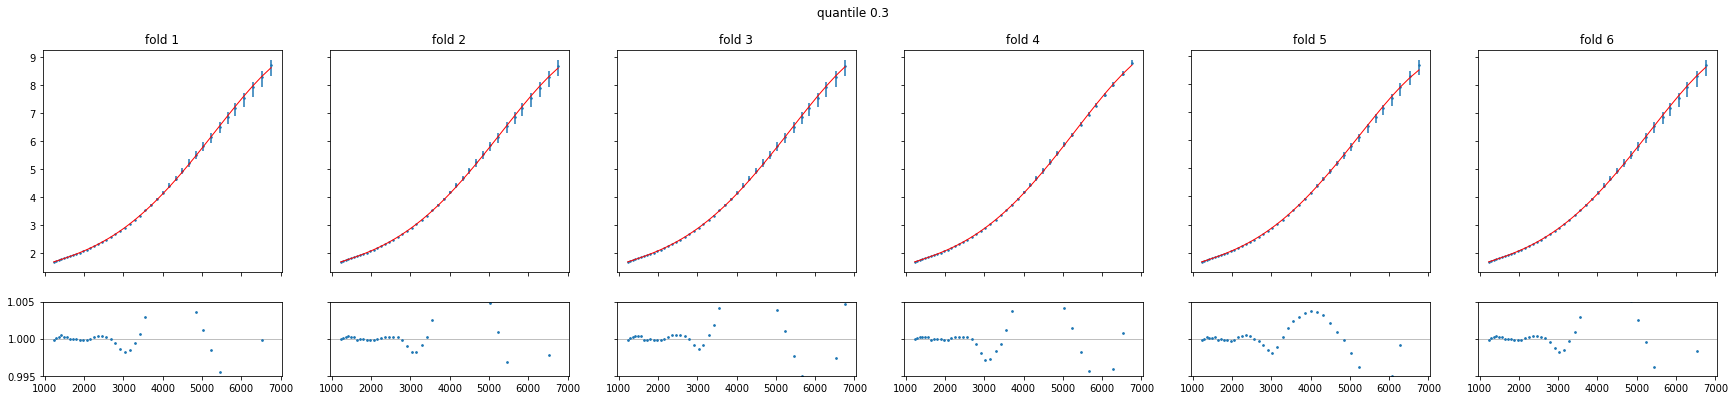

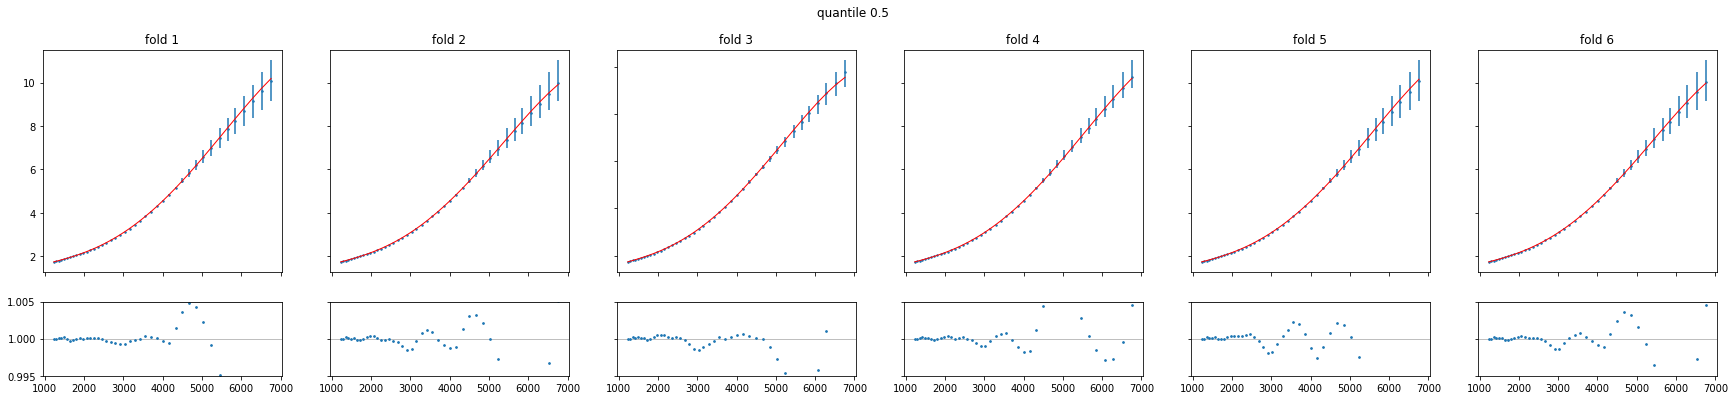

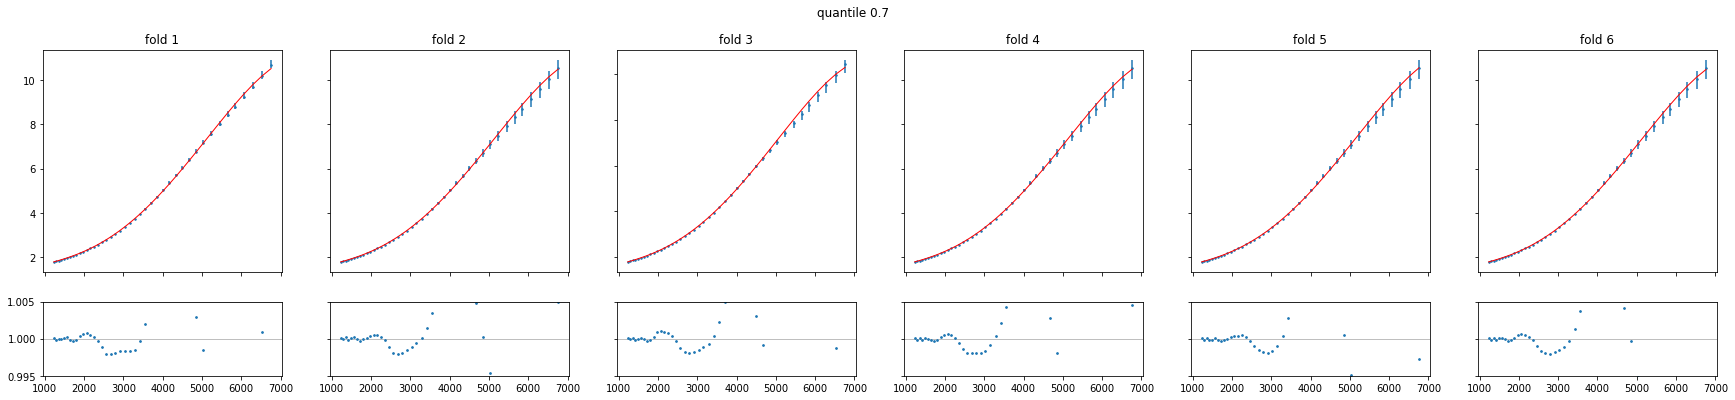

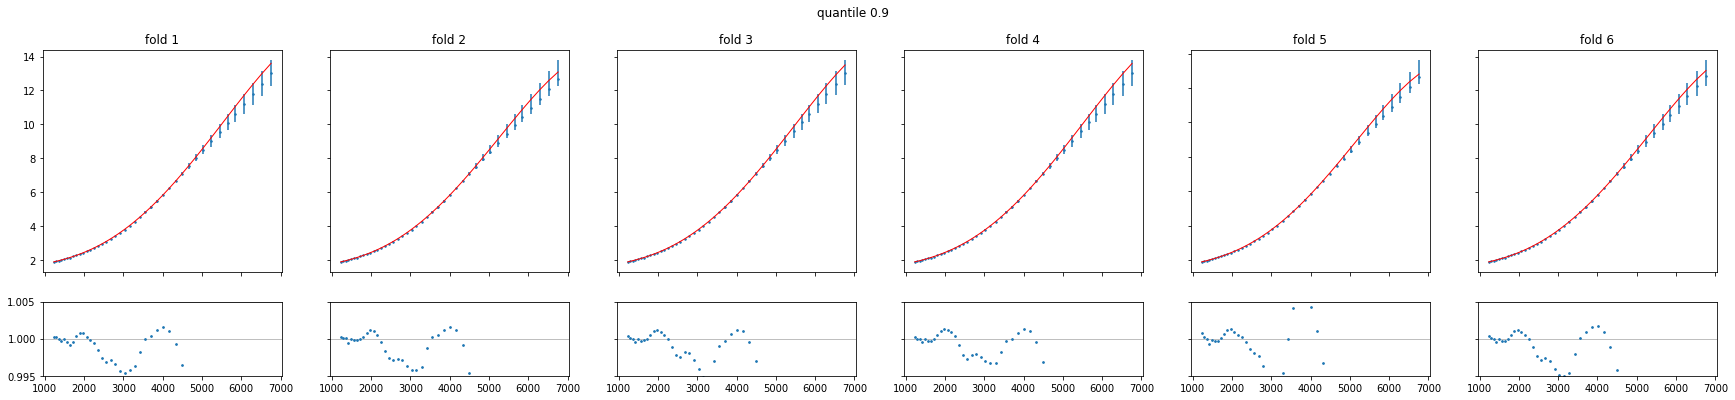

In [22]:
deg = 4
polynomials_per_fold_ord4 = compute_poly1d_fits(deg, envelope_per_fold, quantiles, params) # per kfold -> per quantile
plot_poly_fits(envelope_per_fold, polynomials_per_fold_ord4, quantiles, params, 'np_polyfit_ord'+str(deg))

### degree = 11

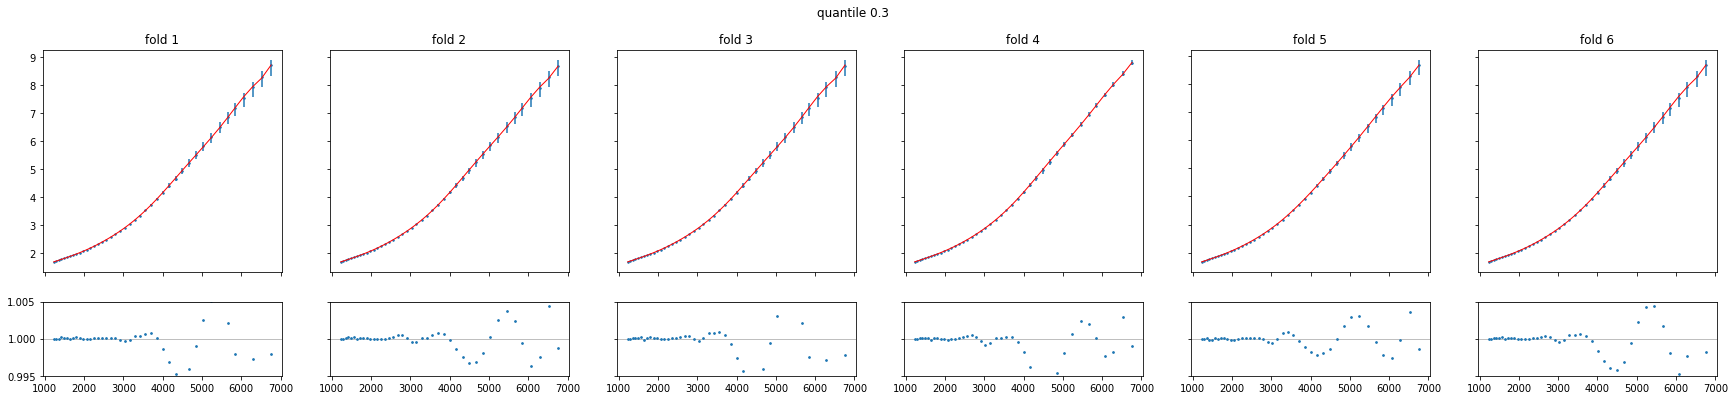

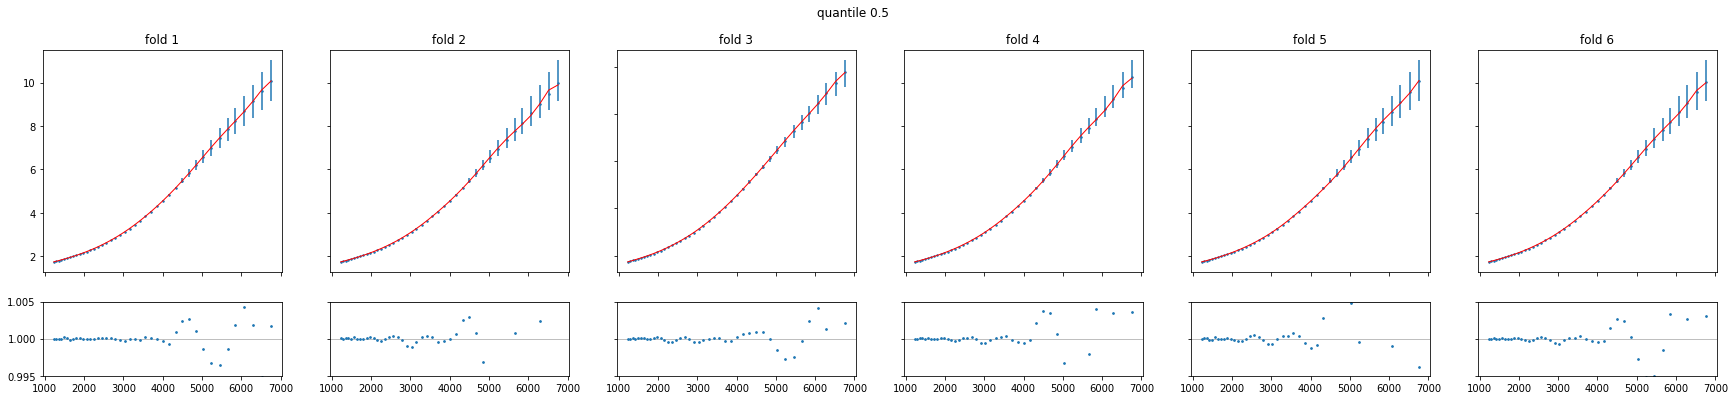

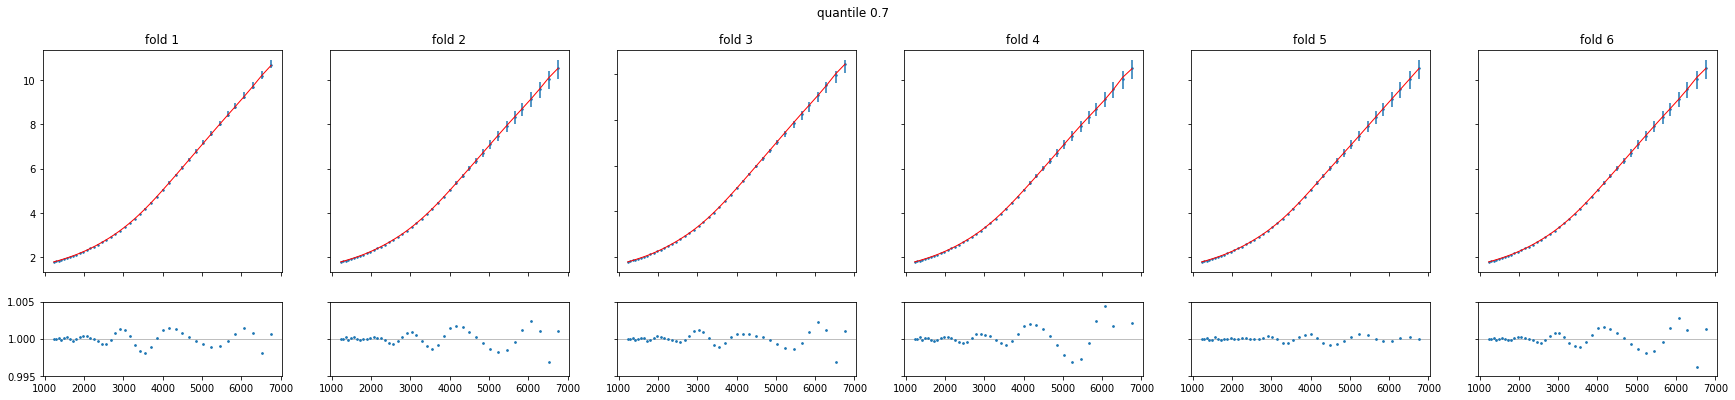

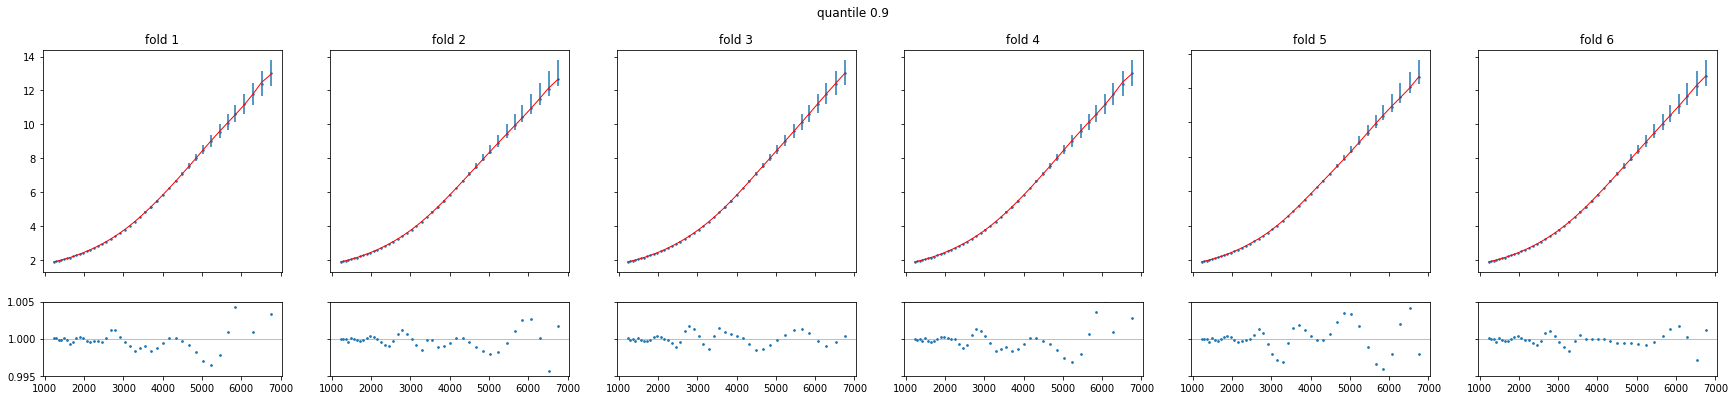

In [23]:
deg = 11
polynomials_per_fold_ord11 = compute_poly1d_fits(deg, envelope_per_fold, quantiles, params)
plot_poly_fits(envelope_per_fold, polynomials_per_fold_ord11, quantiles, params, 'np_polyfit_ord'+str(deg))

# curve_fit

In [24]:
def compute_curve_fits(degree, envelope_per_fold, quantiles, params, fix_point_n=3):
    fit_fun = fit_curve_coeff
    uncert_fun = lambda e: uncertainty_stddev_fixp(e, fix_point_n)
    return fit_poly_from_envelope_forall_folds(fit_fun, uncert_fun, degree, envelope_per_fold, quantiles, params)

### degree = 3

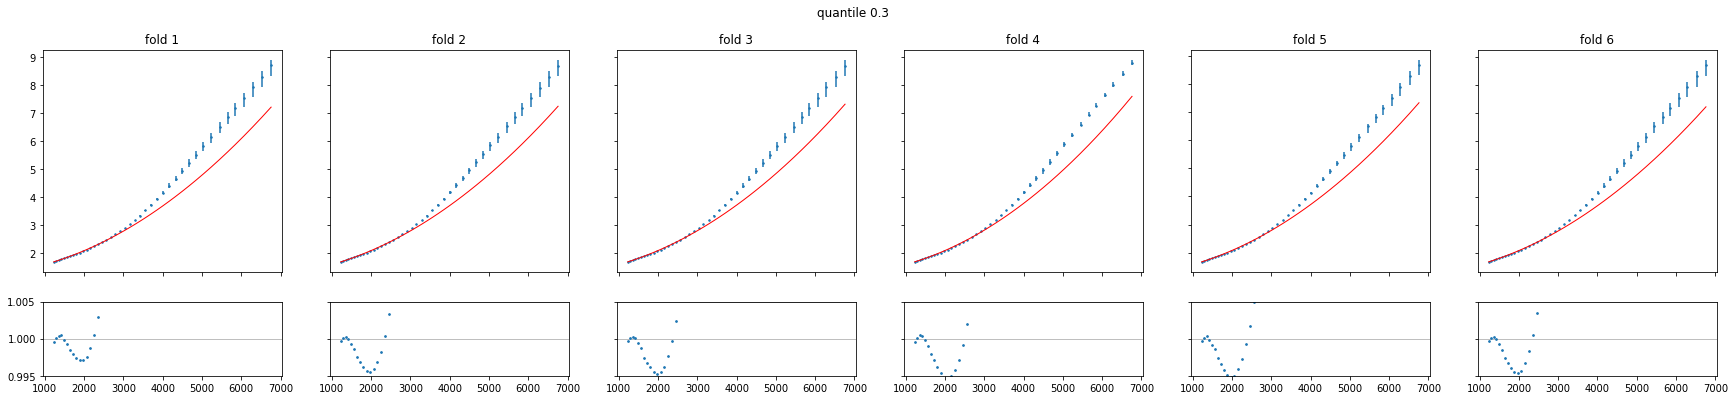

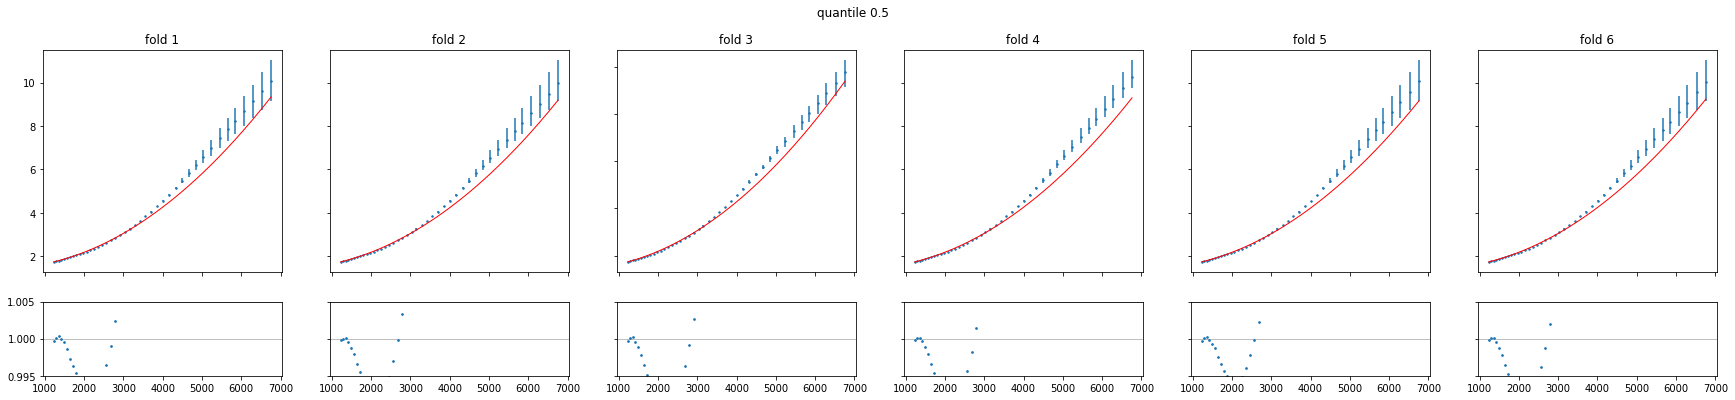

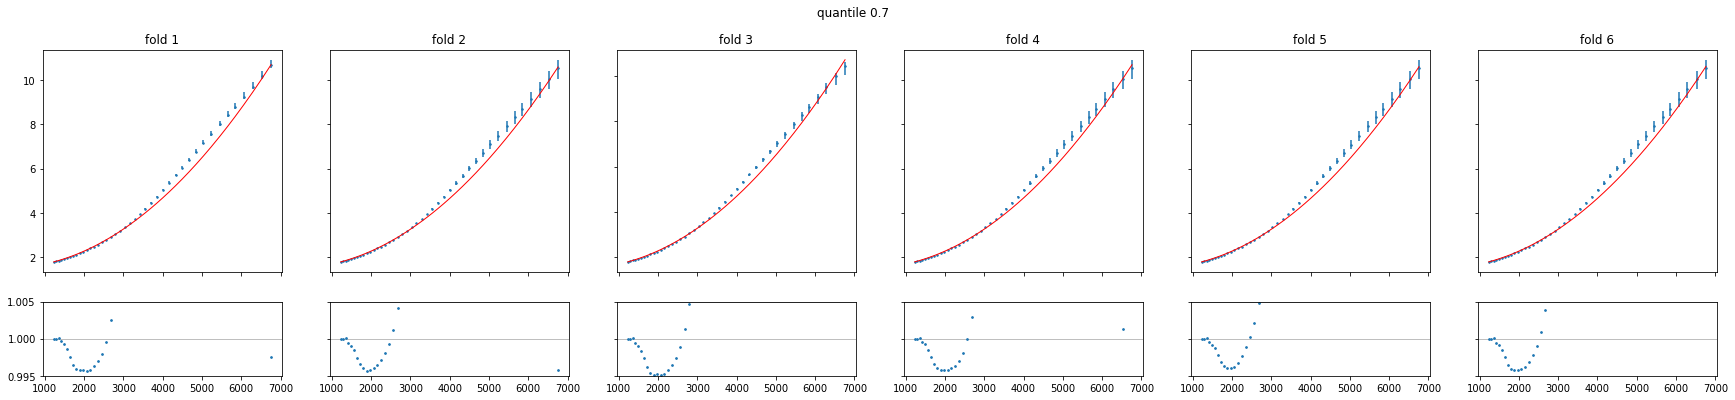

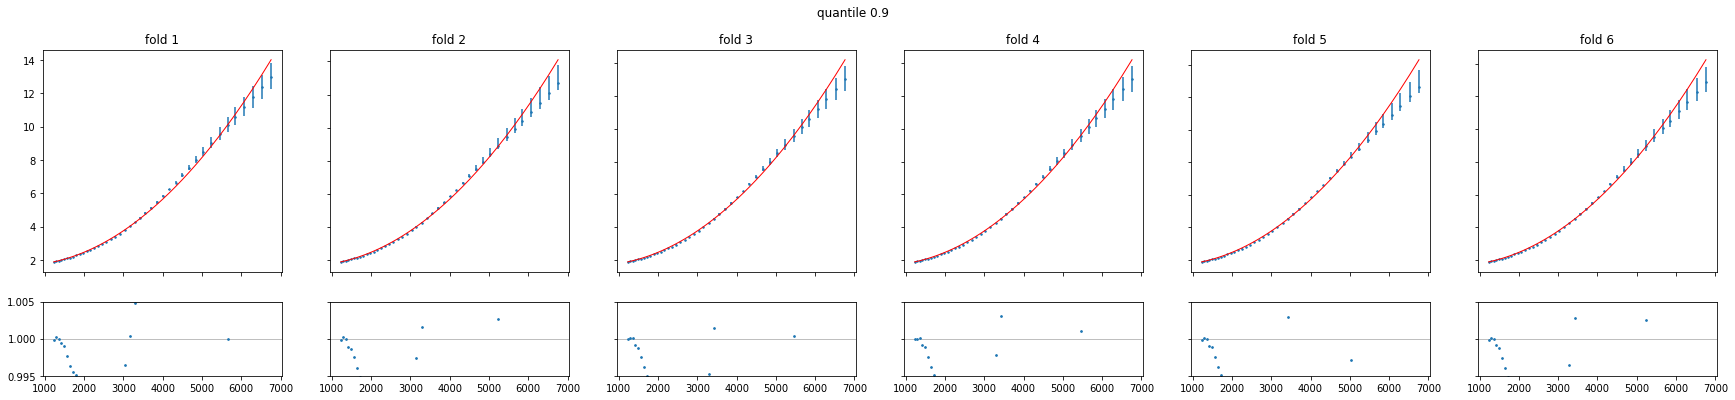

In [25]:
deg = 3
curve_fits_per_fold = compute_curve_fits(deg, envelope_per_fold, quantiles, params)
plot_poly_fits(envelope_per_fold, curve_fits_per_fold, quantiles, params, 'np_curvefit_ord'+str(deg))

### degree = 9

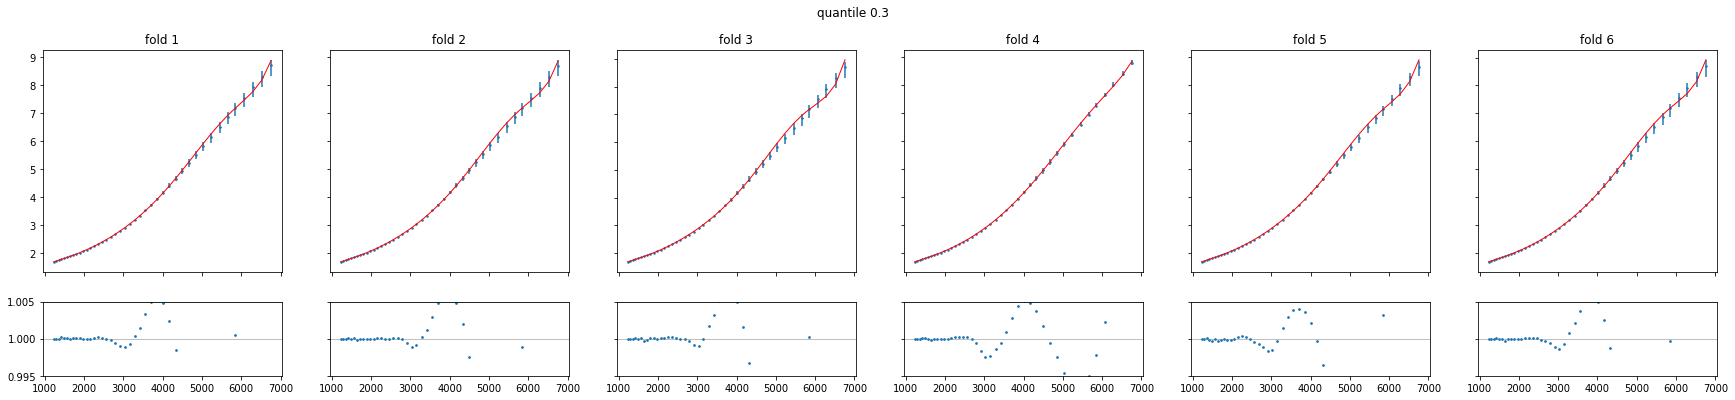

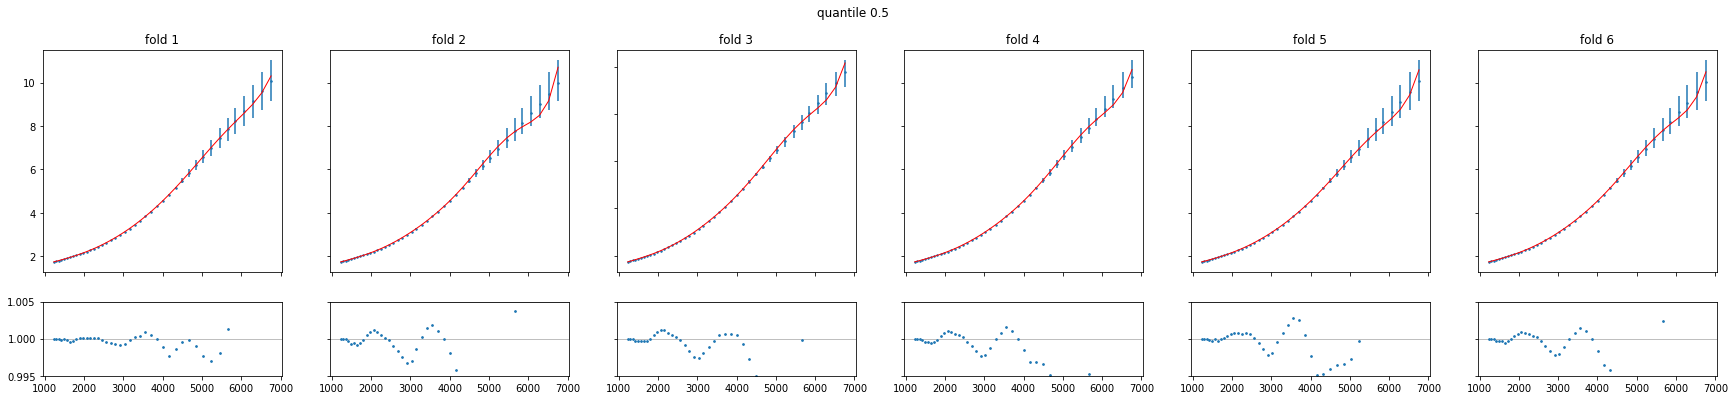

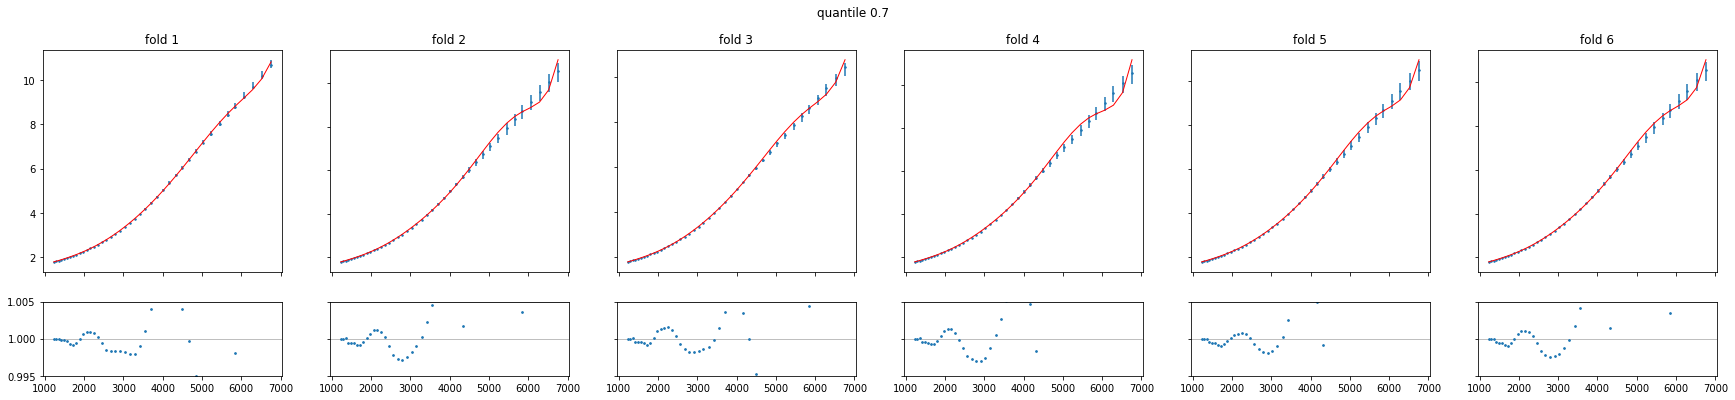

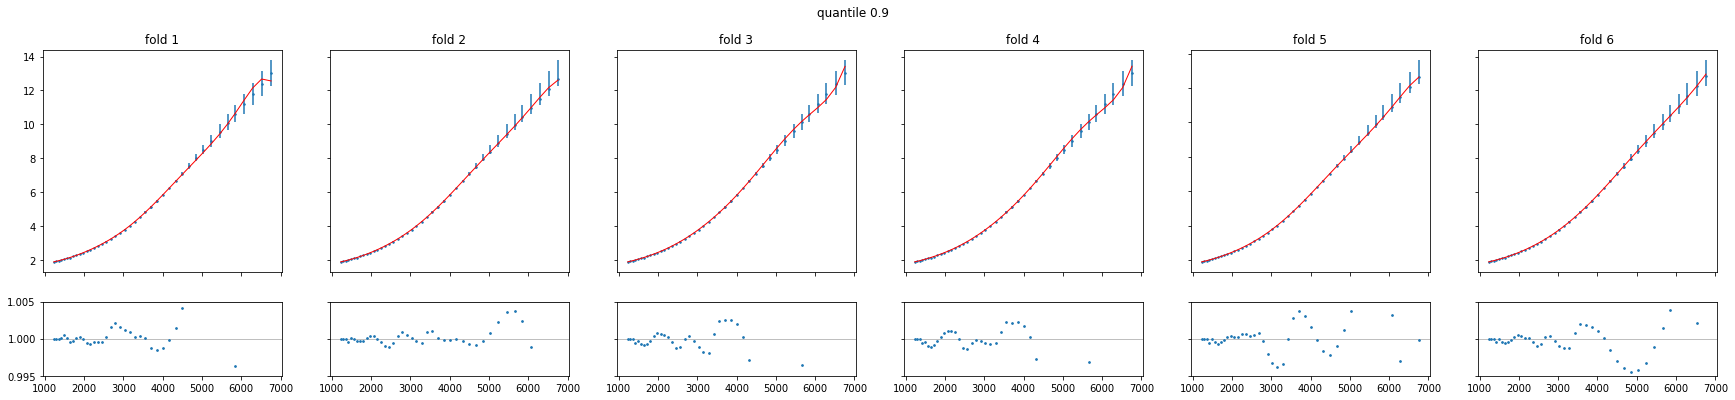

In [26]:
deg = 9
curve_fits_per_fold = compute_curve_fits(deg, envelope_per_fold, quantiles, params)
plot_poly_fits(envelope_per_fold, curve_fits_per_fold, quantiles, params, 'np_curvefit_ord'+str(deg))

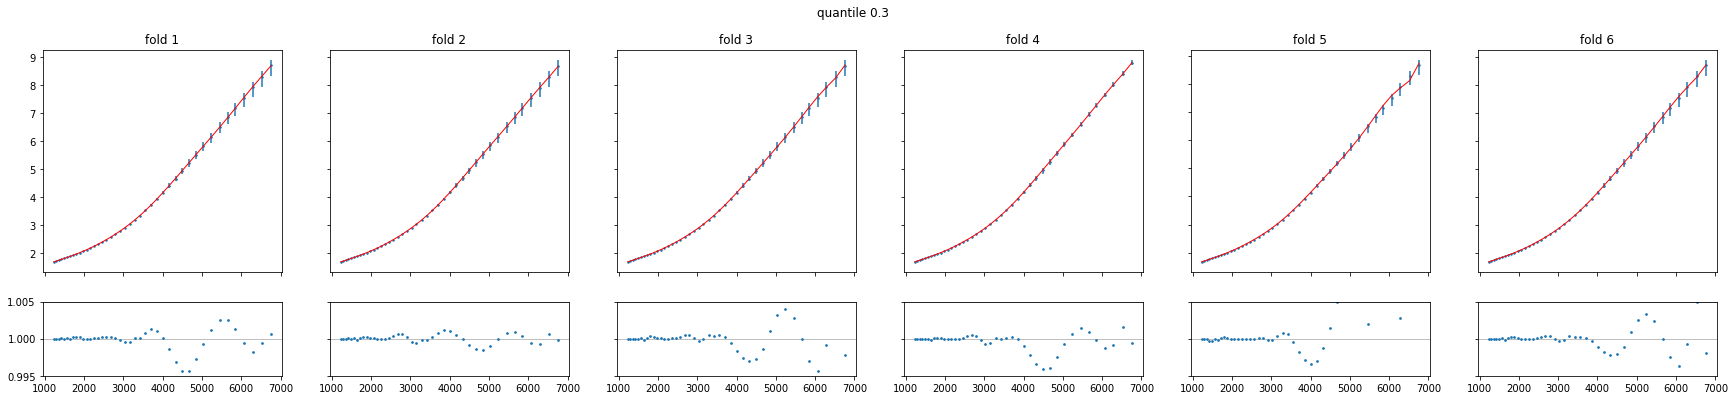

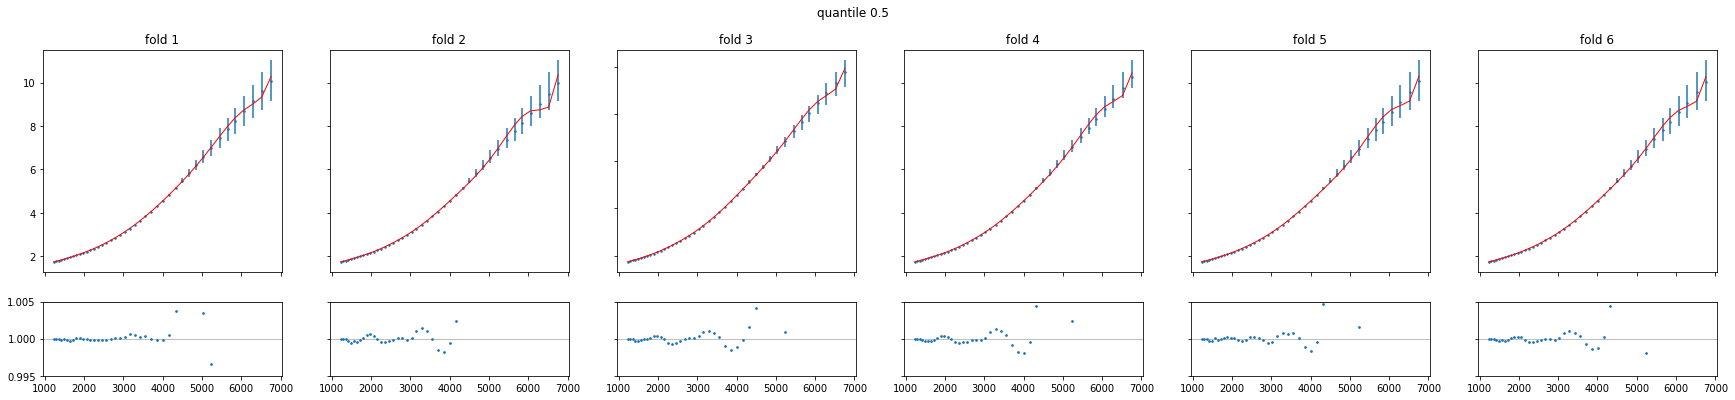

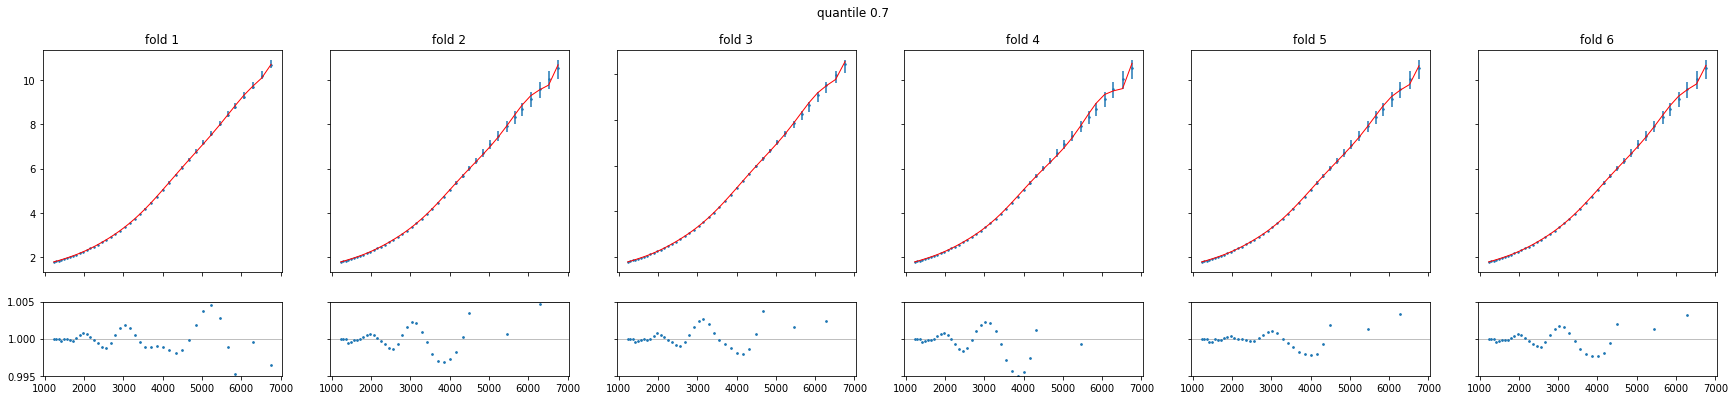

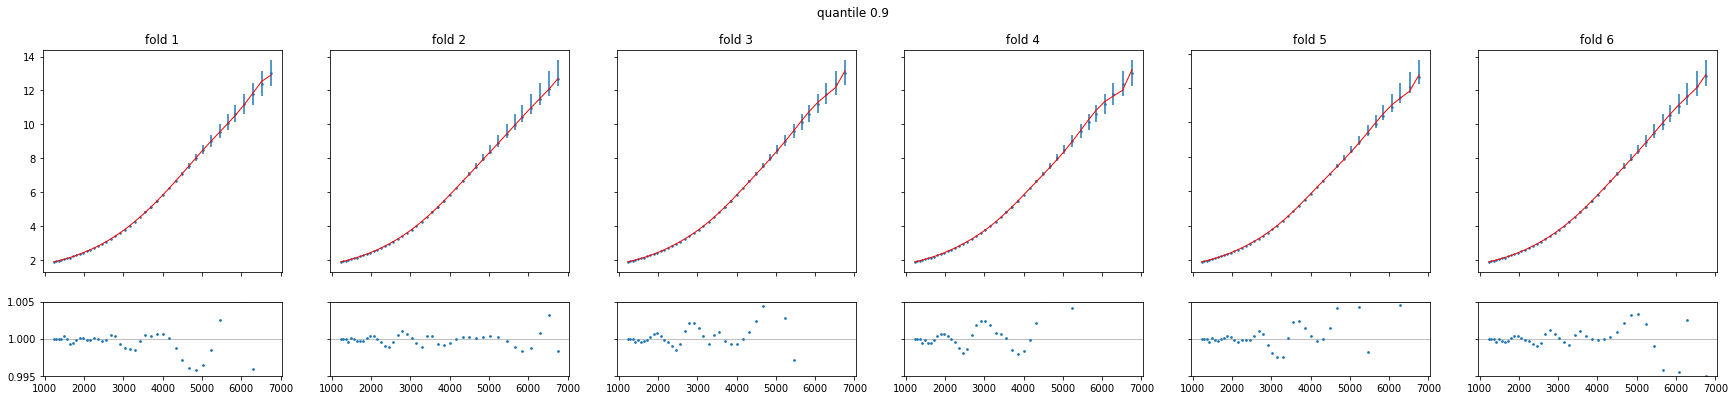

In [27]:
deg = 11
curve_fits_per_fold = compute_curve_fits(deg, envelope_per_fold, quantiles, params)
plot_poly_fits(envelope_per_fold, curve_fits_per_fold, quantiles, params, 'np_curvefit_ord'+str(deg))

## lmfit

In [28]:
def compute_lm_fits(degree, envelope_per_fold, quantiles, params):
    fit_fun = fit_lm_coeff
    uncert_fun = uncertainty_updown #uncertainty_stddev_fixp #uncertainty_yerr #uncertainty_rmse
    return fit_poly_from_envelope_forall_folds(fit_fun, uncert_fun, degree, envelope_per_fold, quantiles, params)

### degree = 3

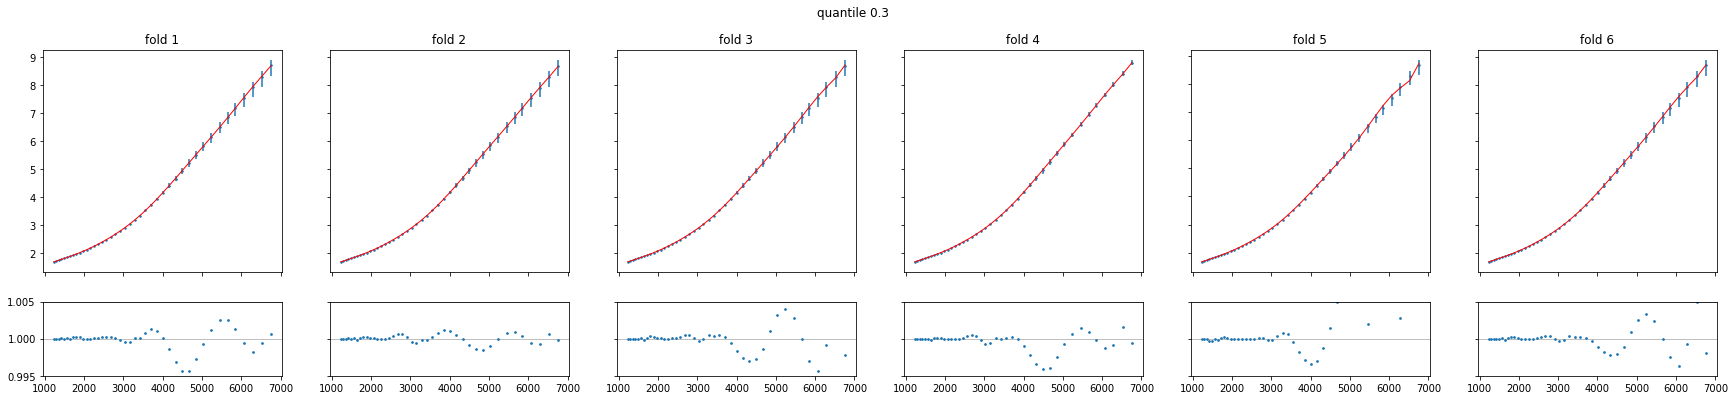

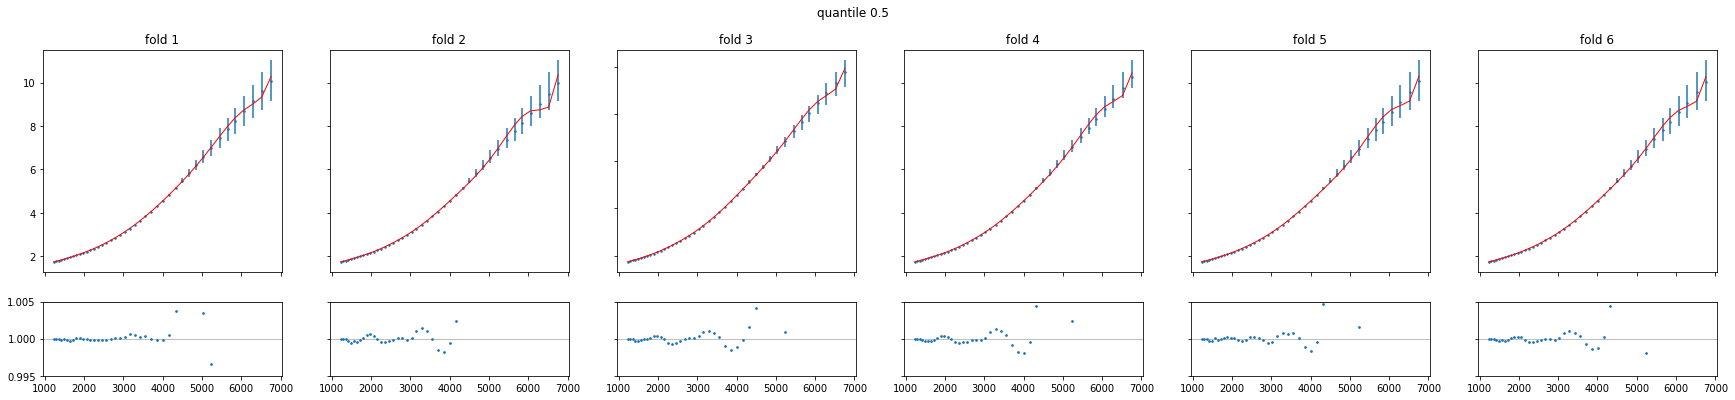

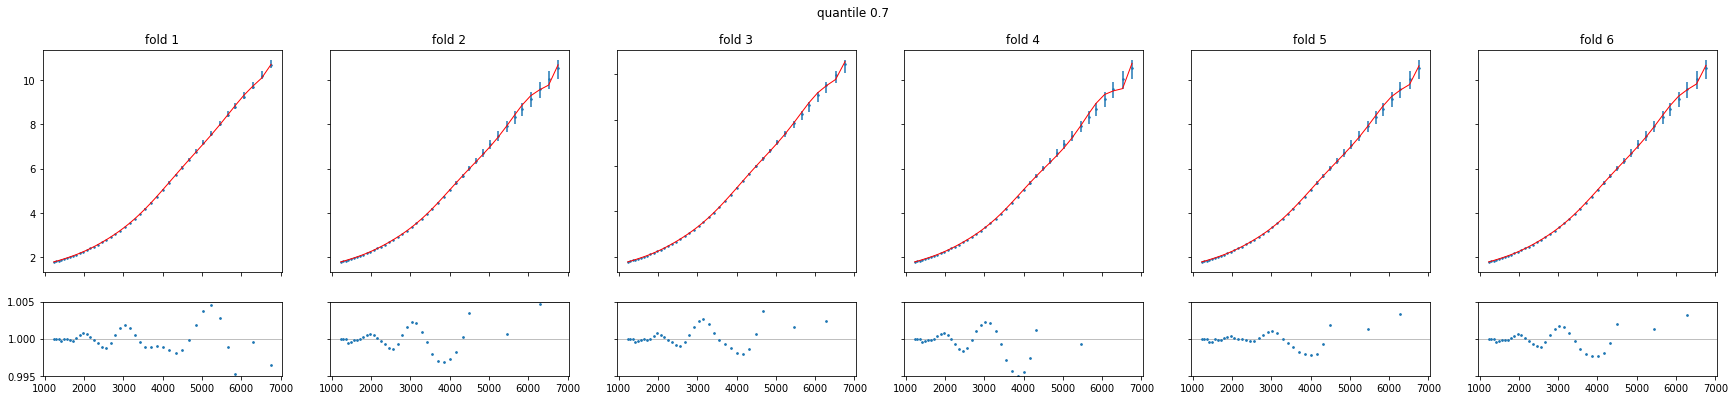

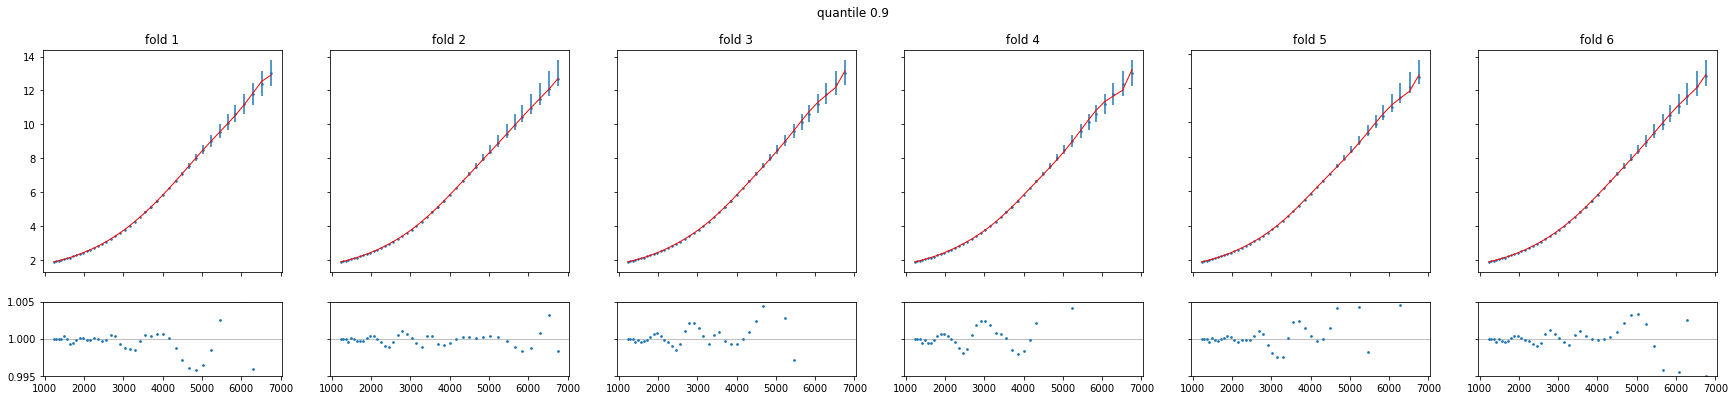

In [29]:
deg = 3
lm_fits_per_fold = compute_lm_fits(deg, envelope_per_fold, quantiles, params)
plot_poly_fits(envelope_per_fold, curve_fits_per_fold, quantiles, params, 'lmfit_ord'+str(deg))

### degree = 7

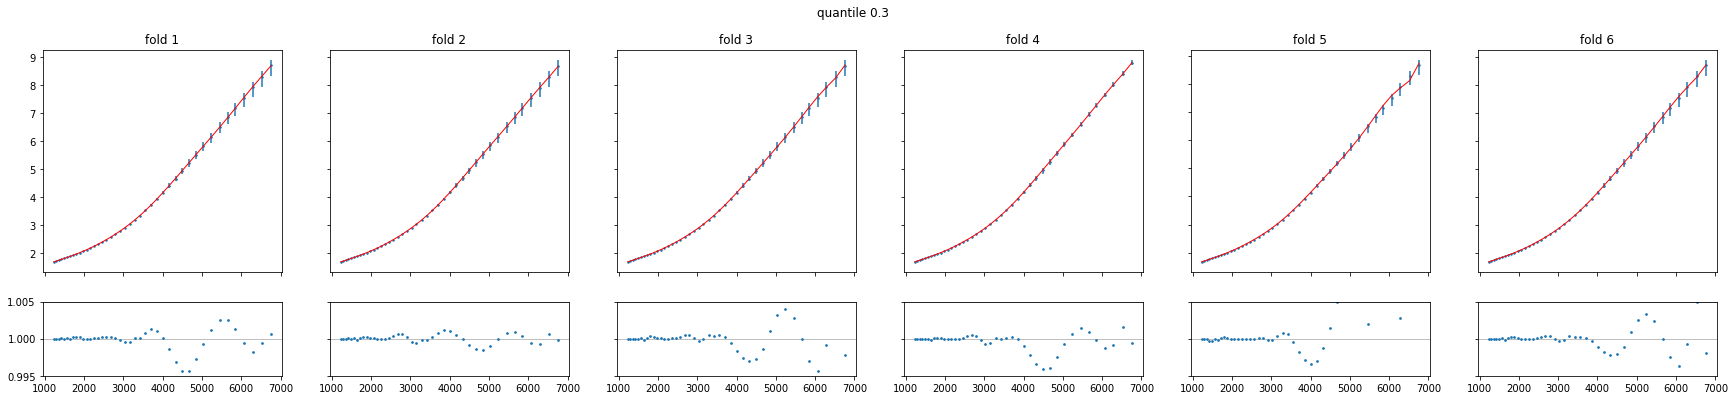

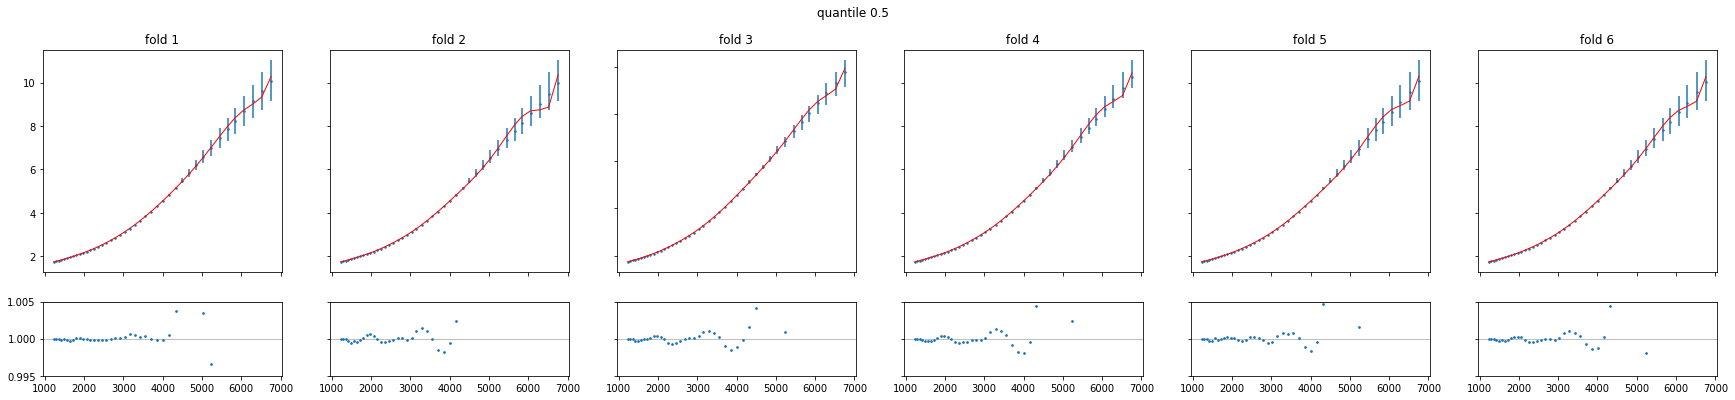

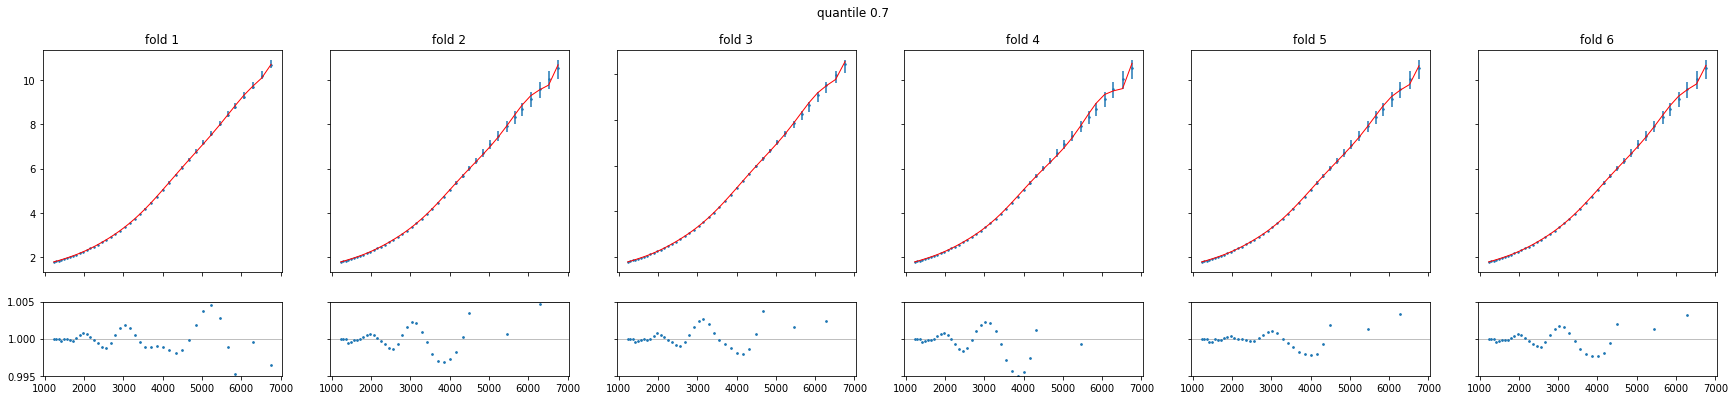

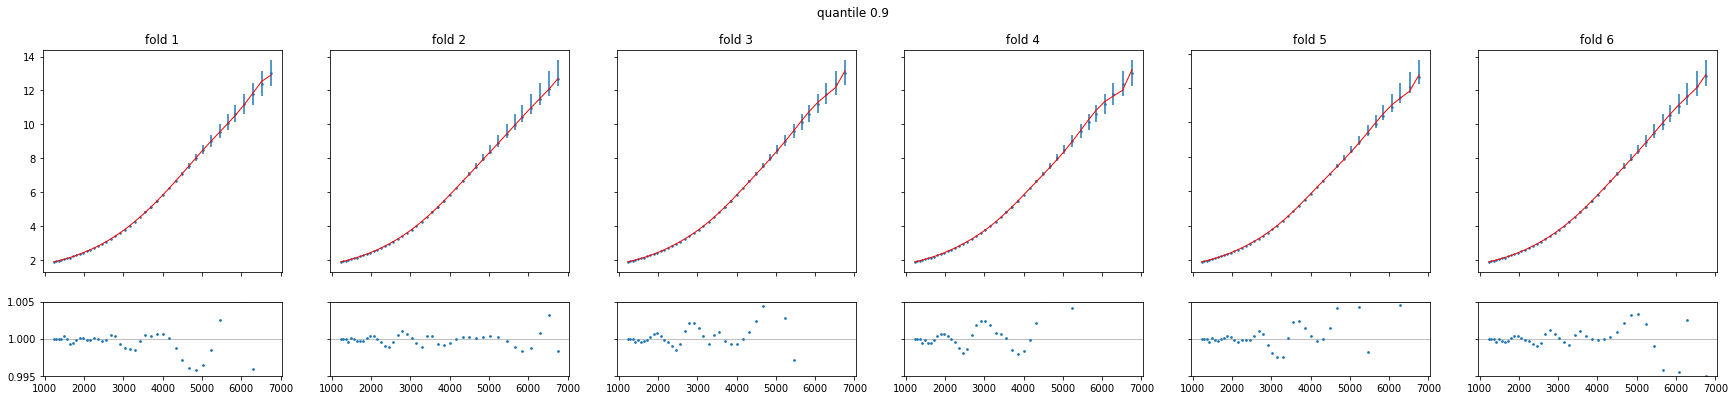

In [30]:
deg = 7
lm_fits_per_fold = compute_lm_fits(deg, envelope_per_fold, quantiles, params)
plot_poly_fits(envelope_per_fold, curve_fits_per_fold, quantiles, params, 'lmfit_ord'+str(deg))

### degree = 11

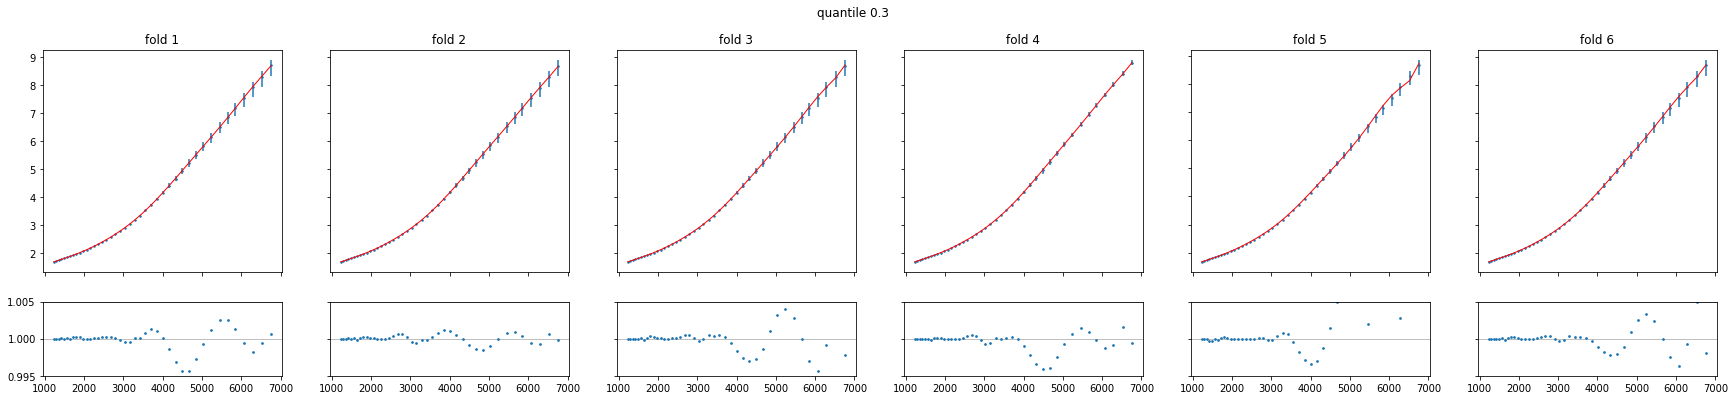

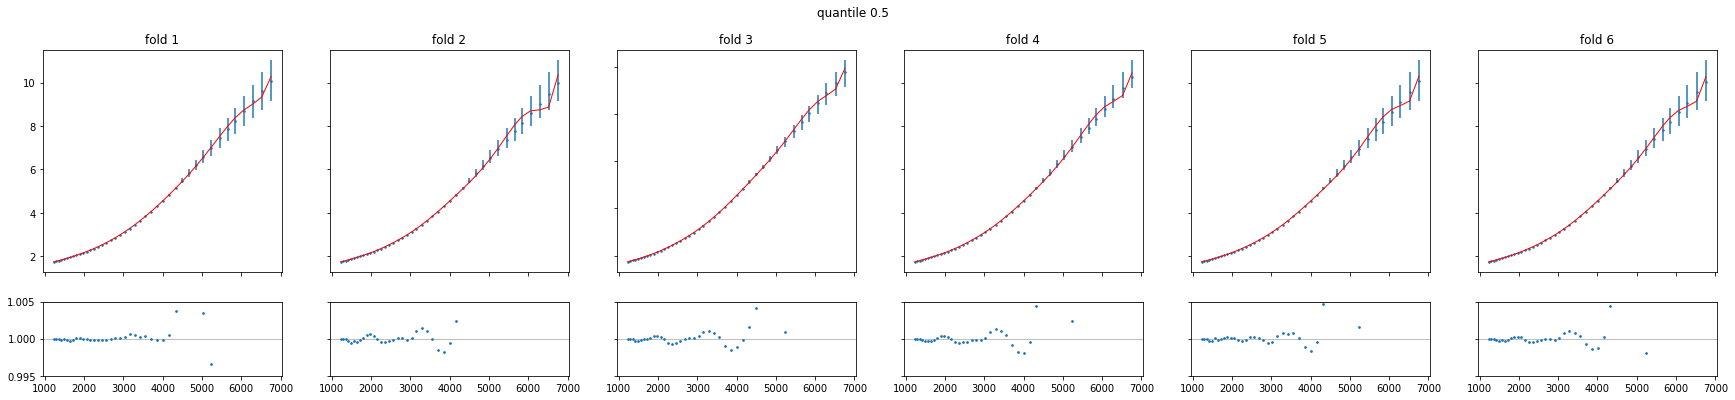

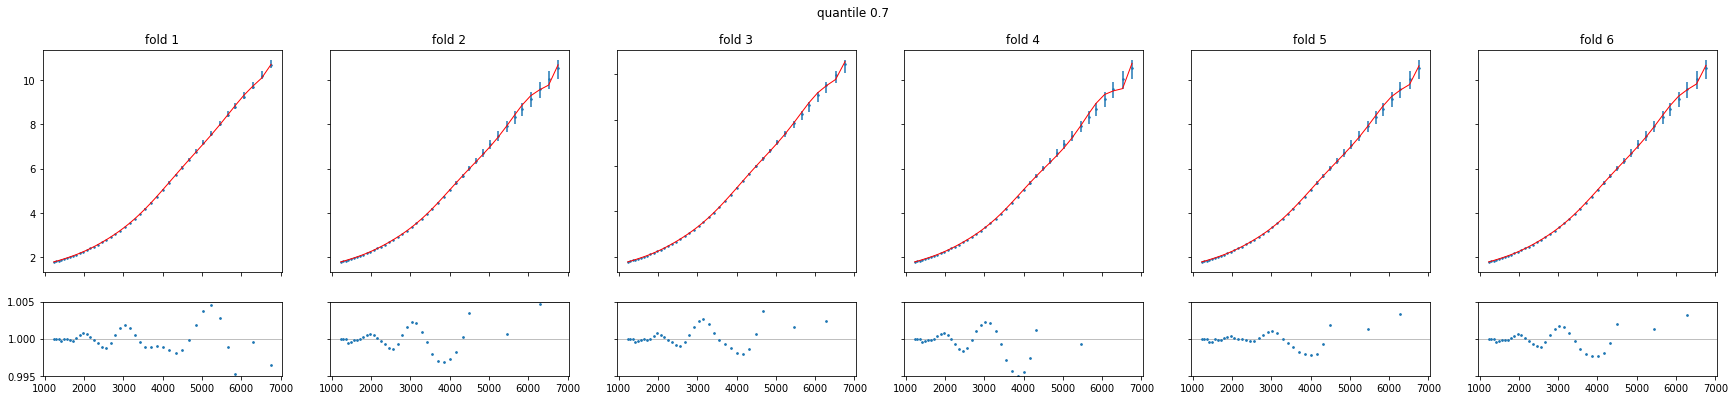

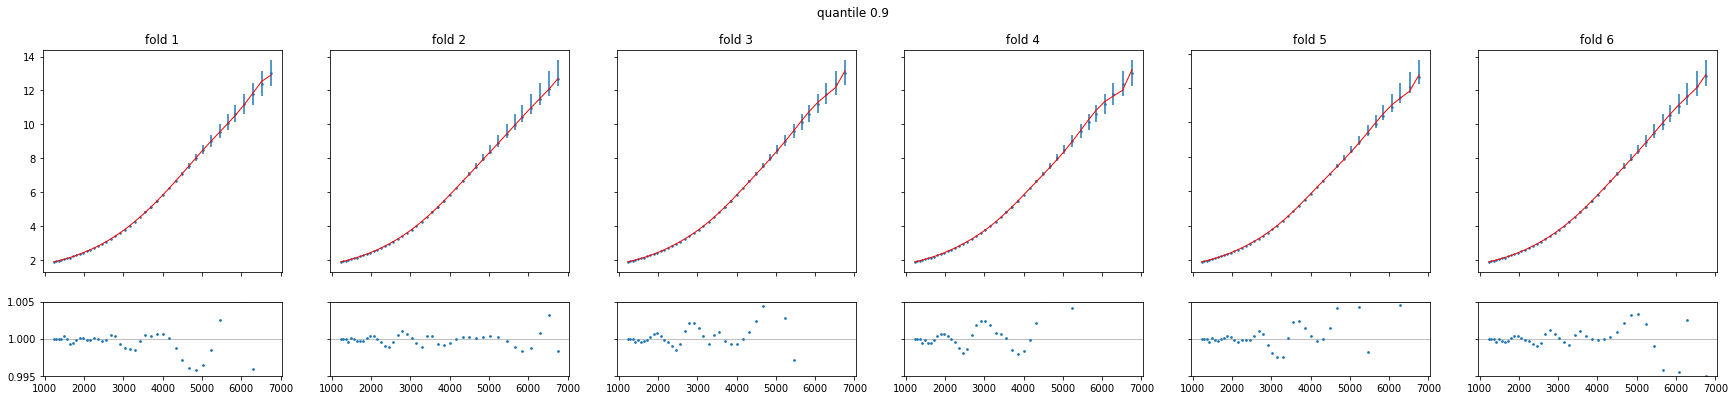

In [31]:
deg = 11
lm_fits_per_fold = compute_lm_fits(deg, envelope_per_fold, quantiles, params)
plot_poly_fits(envelope_per_fold, curve_fits_per_fold, quantiles, params, 'lmfit_ord'+str(deg))